In [1]:
here::here()

### Rcpp: From Simple Examples to Machine Learning
**Dirk Eddelbuettel** - Ketchum

[Code Samples](https://github.com/eddelbuettel/samples-uzuerich-2017-06)

---

Rcpp makes it easy to call C++ functions from R

Users doesn't have to worry about:
* platform;
* compilers;
* R/C interface.

The sourceCpp function:

* The `cppFunction` is great for small examples
* But you should put C++ code in a separate file (`.cpp`)
* `sourceCpp("path/to/file.cpp")`
* The `.cpp` needs a few headers

In [4]:
# R implementation of fib

f <- function(n) {
    if (n < 2) return(n)
    return(f(n-1) + f(n-2))
}
    
sapply(0:10, f)

[1]  0  1  1  2  3  5  8 13 21 34 55

In [5]:
# Rcpp implementation of fib

Rcpp::cppFunction("
    int g(int n) {
        if (n < 2) return(n);
        return(g(n-1) + g(n-2));
    }
")

sapply(0:10, g)

[1]  0  1  1  2  3  5  8 13 21 34 55

In [6]:
rbenchmark::benchmark(f(25), g(25), order = 'relative')[,1:4]

,test,replications,elapsed,relative
2,g(25),100,0.039,1.000
1,f(25),100,9.084,232.923


In [7]:
# dumb mean in R

mean_r = function(x) {
    n = length(x)
    m = 0
    for(i in seq_along(x))
      m = m + x[i]/n
    m
}

# C++ implementation
    
Rcpp::cppFunction('
    double mean_c(NumericVector x){
        int i;
        int n = x.size();
        double mean = 0;

        for(i=0; i<n; i++) {
            mean = mean + x[i]/n;
        }
        return mean;
    }'
)
    
x = rnorm(1e4)

z = microbenchmark::microbenchmark(
    mean(x),
    mean_r(x),
    mean_c(x)
)
print(z)

Unit: microseconds
      expr     min       lq      mean   median       uq      max neval
   mean(x)  18.248  18.5525  20.31404  18.7895  19.1395  133.699   100
 mean_r(x) 433.966 434.3100 476.46842 435.1180 445.0620 3340.324   100
 mean_c(x)  38.811  39.1020  46.58080  39.2260  39.4715  653.192   100


### Efficient R Programming
**Colin Gillespie** - Jumping Rivers | Newcastle University

[Book](https://github.com/csgillespie/efficientR)

---

* R reduces time spent coding dramatically...
* But it's very easy to write programs that are incredibly slow.

In [10]:
# BAD - Don't try to bring your fancy C shit here

bad_hit <- function(n = 100) {
    hit = NULL
    for(i in 1:n) {
        if(runif(1) < 0.3) 
            hit[i] = TRUE
        else
            hit[i] = FALSE
    }
}

# GOOD

good_hit <- function(n = 100) {
    hit = runif(n) < 0.3
}

rbenchmark::benchmark(
    good_hit(1000), bad_hit(1000), order = "relative", replications = 100)

test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
good_hit(1000),100,0.005,1.0,0.005,0.000,0,0
bad_hit(1000),100,0.191,38.2,0.149,0.043,0,0


In [11]:
# Avoid `rbind` at all costs
# FIRST RULE OF R CLUB IS TO NEVER GROW A VECTOR
# pre-allocate (baye a bayesian)

# THIS IS BAD

bad_df_add <- function(n) {
    df1 = data.frame(a = character(0), b = numeric(0))
    for(i in 1:n)
        df1 = rbind(df1, 
                data.frame(a = sample(letters, 1), b = runif(1)))
    return(df1)
}
    
# THIS IS GOOD

good_df_add <- function(n) {
    df2 <- tibble::tibble(a = character(n), b = numeric(n))
    
    for(i in 1:10) {
        df2[i, "a"] <- sample(letters, 1)
        df2[i, "b"] <- runif(1)
    }
    return(df2)
}

z <- rbenchmark::benchmark(
    good_df_add(1000), bad_df_add(1000), 
    order = "relative", replications = 5)

print(z)

               test replications elapsed relative user.self sys.self user.child
1 good_df_add(1000)            5   0.048    1.000     0.048    0.000          0
2  bad_df_add(1000)            5   2.373   49.437     2.312    0.058          0
  sys.child
1         0
2         0


In [12]:
# Always vectorize 

# BAD

x = rnorm(10)
ans = NULL
for(i in 1:length(x)) {
    if(x[i] < 0) 
        ans = c(ans, x[i])
}

# GOOD

x = x[x < 0]

### Sports Betting and R: How R is changing the sports betting world
**Marco Blume** - Pinnacle

[Slides](http://schd.ws/hosted_files/user2017/8f/useR2017_PPT-Final.ppt)

In [2]:
# install.packages("odds.converter")
library(odds.converter)

In [6]:
odds.us2dec(-115)
odds.prob2malay(0.5)

[1] 1.869565

[1] -1

In [7]:
df <- data.frame(
    Home = c(1.5,1.8,1.9),
    Away = c(2.9,2.2,2.05)
)

odds.fv(df,input = "dec",output = "prob")

Home,Away
0.6590909,0.3409091
0.5500000,0.4500000
0.5189873,0.4810127


In [9]:
library(dplyr)

df <- data.frame(
    Home = c(1.5,1.8,1.9),
    Away = c(2.9,2.2,2.05)
)

df %>%
    rowwise() %>%
    mutate(FairHome = odds.fv(Home, Away,
        input = "dec",
        output = "prob")[1]) %>% 
    mutate(FairAway = 1 - FairHome)

Home,Away,FairHome,FairAway
1.5,2.90,0.6590909,0.3409091
1.8,2.20,0.5500000,0.4500000
1.9,2.05,0.5189873,0.4810127


### Daff: diff, patch and merge for data.frames
**Edwin de Jonge**

[Slides](http://schd.ws/hosted_files/user2017/09/daff.pdf)

---

Daff is a diff for data.frames
* Detect changes: diff_data, differs_from 
* Store and restore diff: write_diff, read_diff 
* Patch updated data: patch_data, merge_data 
* Render a diff: render_diff

In [12]:
# devtools::install_github("edwindj/daff")
library(daff)
library(tidyverse)

In [14]:
data("starwars")

sw_small <- starwars %>% 
    filter(row_number() <= 10) %>% 
    select(name, homeworld, species, birth_year)

sw_small_changed <- sw_small %>% 
    filter(name != "R5-D4") %>% 
    rowwise() %>% 
    mutate(alive = rbinom(1, size = 1, prob = 0.5)) %>% 
    select(-birth_year) %>% 
    mutate(species = ifelse(name == "R2-D2", "Robot", species)) %>% 
    bind_rows(tibble(name = "Max", homeworld = "Earth", species = "Human", alive = 1)) %>% 
    arrange(alive)

In [23]:
library(IRdisplay)
library(repr)
options(repr.vector.quote=FALSE)

html <- diff_data(sw_small, sw_small_changed,
        always_show_order = FALSE, 
        ordered = FALSE) %>% 
    render_diff(
        view = FALSE, 
        fragment = TRUE, 
        title = '',
        summary = FALSE, 
        use.DataTable = FALSE)

display_html(html)

!,,,,+++,---
@@,name,homeworld,species,alive,birth_year
+,Luke Skywalker,Tatooine,Human,0,19
+,C-3PO,Tatooine,Droid,0,112
⇒,R2-D2,Naboo,Droid → Robot,0,33
+,Darth Vader,Tatooine,Human,0,41.9
+,Leia Organa,Alderaan,Human,0,19
+,Owen Lars,Tatooine,Human,0,52
+,Beru Whitesun lars,Tatooine,Human,1,47
---,R5-D4,Tatooine,Droid,null,NA
+,Biggs Darklighter,Tatooine,Human,1,24


### Modules in R
**Sebastian Warnholz**

[Slides](http://schd.ws/hosted_files/user2017/78/170707_useR17_SWarnholz.pdf)

In [3]:
# devtools::install_github("wahani/modules")
library(modules)

In [4]:
# quick-start example

example <- module({
    boring_function <- function() {"boring output"}
})

example$boring_function()

[1] "boring output"

In [5]:
# example for seperate scripts

code <- "
import('stats', 'median')
functionWithDep <- function(x) median(x)
"

fileName <- tempfile(fileext = ".R")
writeLines(code, fileName)

m <- use(fileName)
m$functionWithDep(1:2)

[1] 1.5

In [9]:
# personal example

pf <- use("personal_functions.R")

pf$kink(
    x = 0.132,
    intercept = 100,
    slopes = c(1500, 1100, 3100, 1500),
    breaks = c(0.06, 0.14, 0.16)
)

[1] 269.2

### FFTrees: An R package to create, visualise and use fast and frugal decision trees

**Nathaniel Phillips**

[GitHub](http://www.github.com/ndphillips/FFTrees)

In [1]:
# install.packages("FFTrees")  
library(FFTrees)

   a      
  / \     
 0   b  
    / \   
   0   1  
FFTrees v1.3.2. Email: Nathaniel.D.Phillips.is@gmail.com
FFTrees.guide() opens the package guide. Citation info at citation('FFTrees')


In [3]:
data("titanic")

titanic_fft <- FFTrees(survived ~., data = titanic, main = "Titanic", decision.labels = c("Died", "Survived"))

Growing FFTs with ifan
Fitting non-FFTrees algorithms for comparison (you can turn this off with comp = FALSE) ...


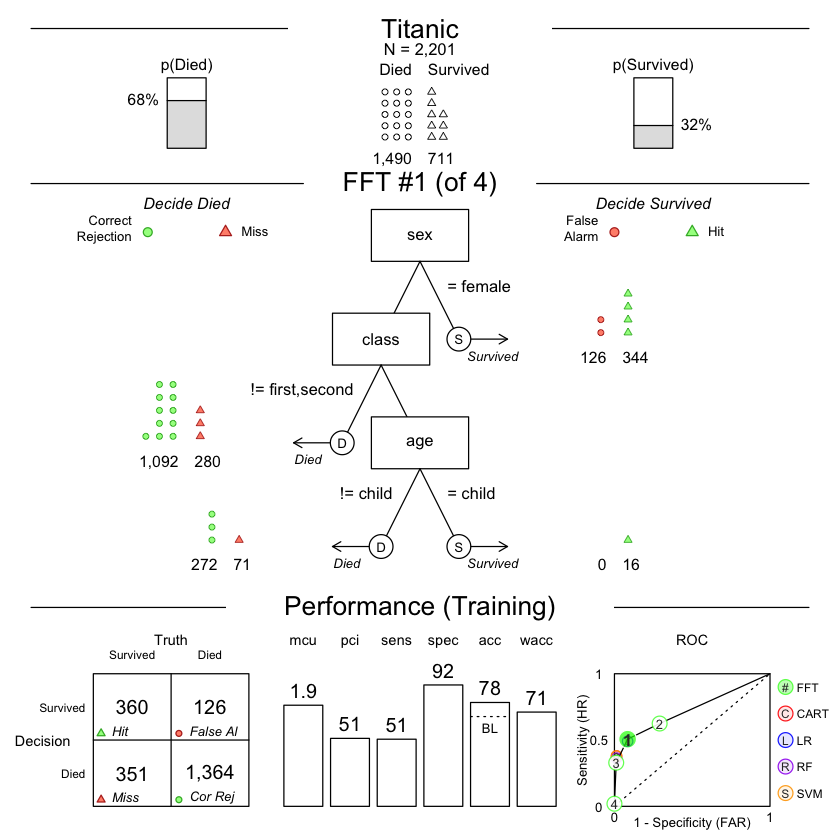

In [4]:
plot(titanic_fft)

In [5]:
inwords(titanic_fft)

$v1
[1] "If sex = {female}, predict Survived"                                           
[2] "If class != {first,second}, predict Died"                                      
[3] "If age != {child}, predict Died, otherwise, if age = {child}, predict Survived"

$v2
[1] "If sex = {female}, predict Survived. If class != {first,second}, predict Died. If age != {child}, predict Died, otherwise, if age = {child}, predict Survived"

In [6]:
data(heartdisease)

heart_fft <- FFTrees(
    formula = diagnosis ~.,
    data = heart.train,
    data.test = heart.test,
    main = "Heart Disease",
    decision.labels = c("Low-Risk", "High-Risk"))

Growing FFTs with ifan
Fitting non-FFTrees algorithms for comparison (you can turn this off with comp = FALSE) ...


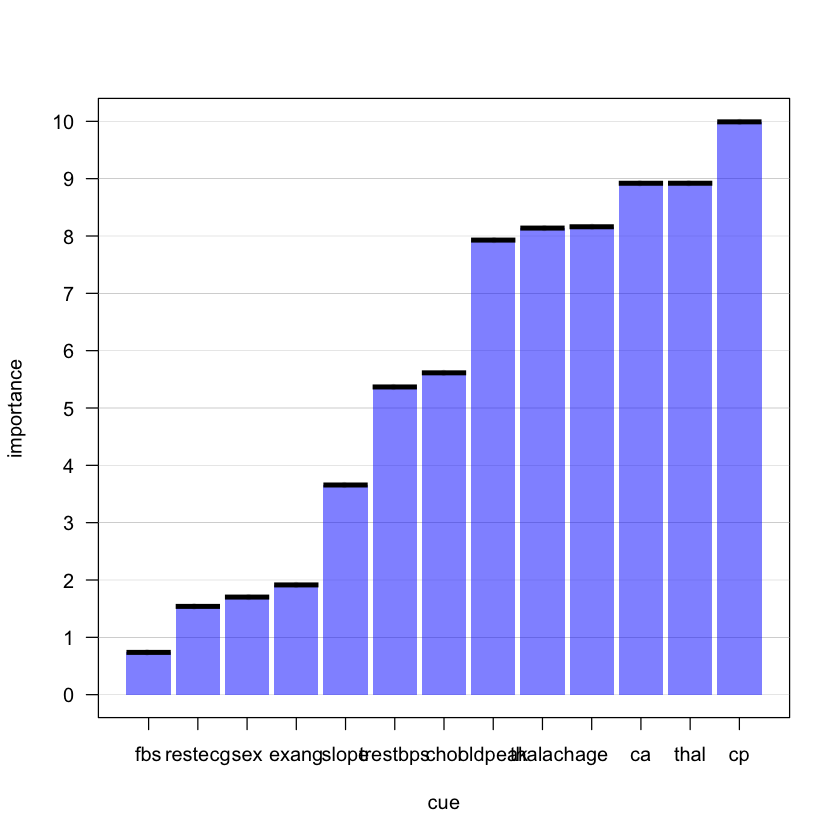

In [7]:
heart_importance <- heart_fft$comp$rf$model$importance
heart_importance <- data.frame(cue = rownames(heart_fft$comp$rf$model$importance), importance = heart_importance[,1])
heart_importance <- heart_importance[order(heart_importance$importance),]
yarrr::pirateplot(formula = importance ~ cue, data = heart_importance, sortx = "s", bar.f.o = .5, bar.f.col = "blue")


### The R6 Class System
**Winston Chang**

[GitHub](https://github.com/wch/R6)

---

R6 is an encapsulated OOP system. 

Good in db connections, shiny sessions and processx systems processes

Use R6 when you:
* don't want to pollute environments 
* want to just expose certain things

In [8]:
# install.packages('R6')
library(R6)

In [9]:
Accumulator <- R6Class(classname = "Accumulator",
    public = list(
        sum = 0, 
        add = function(x) {
            self$sum <- self$sum + x # use self to access object properties
            invisible(self)
        }
    )
)

x <- Accumulator$new() # instantiate the class
x$add(4)
x$add(10)$add(10)
x$sum

[1] 24

In [10]:
# Stack class

Stack <- R6Class("Stack", 
    public = list(
        push = function(x) {
            private$items[[self$size() + 1]] <- x
            invisible(self)
        },
        pop = function() {
            if (self$size() == 0)
                stop("No more items on stack")
            item <- private$items[[self$size()]]
            private$items <- private$items[-self$size()]
            item
        },
        size = function() {
            length(private$items)
        }
    ),
    private = list(items = list()) # not externally available
)

s <- Stack$new()
s$push(1)
s$push(5:10)
s$push("text")

s$pop()
s$pop()
s$pop()

[1] "text"

[1]  5  6  7  8  9 10

[1] 1